# **Занятие 2.**

# [Pytorch autograd](https://pytorch.org/docs/stable/autograd.html)

[Tutorial](https://www.youtube.com/watch?v=MswxJw-8PvE)

[Slides](https://app.diagrams.net/#G1bq3akhmA5DGRCiFYJfNPSn7il2wvCkEY)

[Torch C++ Binary operations](https://github.com/pytorch/pytorch/blob/c5872e6d6d8fd9b8439b914c143d49488335f573/aten/src/ATen/native/cpu/BinaryOpsKernel.cpp)

[Torch C++ Activations](https://github.com/pytorch/pytorch/blob/c5872e6d6d8fd9b8439b914c143d49488335f573/aten/src/ATen/native/cpu/Activation.cpp)

In [1]:
import torch

In [2]:
def show_tensor_params(*tensors):
  for x in tensors:
    print('---')
    print(f"data - {x.data}")
    print(f"grad - {x.grad}")
    print(f"grad_fn - {x.grad_fn}")
    print(f"req_grad - {x.requires_grad}")
    print(f"is_leaf - {x.is_leaf}")

In [3]:
x = torch.tensor(5.0)
show_tensor_params(x)

---
data - 5.0
grad - None
grad_fn - None
req_grad - False
is_leaf - True


All Tensors that have **requires_grad** which is **False** will be leaf Tensors by convention.

For Tensors that have **requires_grad** which is **True**, they will be leaf Tensors if they were created by the user. This means that they are not the result of an operation and so **grad_fn** is None.

Only leaf Tensors will have their **grad** populated during a call to backward(). To get grad populated for non-leaf Tensors, you can use retain_grad().[[Link]](https://pytorch.org/docs/stable/generated/torch.Tensor.is_leaf.html#torch.Tensor.is_leaf)

In [4]:
#Slide A4
a = torch.tensor(2.0, requires_grad=True)
b = torch.tensor(3.0)
c = a*b

c.backward()
# (2 * c).backward()

In [5]:
show_tensor_params(a, b, c)

---
data - 2.0
grad - 3.0
grad_fn - None
req_grad - True
is_leaf - True
---
data - 3.0
grad - None
grad_fn - None
req_grad - False
is_leaf - True
---
data - 6.0
grad - None
grad_fn - <MulBackward0 object at 0x7bfdab766a70>
req_grad - True
is_leaf - False


<ipython-input-2-168b1ceafb31>:5: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:486.)
  print(f"grad - {x.grad}")


In [ ]:
#Slide Simple5

In [29]:
a = torch.tensor(2.0, requires_grad=True)
b = torch.tensor(3.0, requires_grad=True)
c = a*b
d = torch.tensor(4.0, requires_grad=True)
e = c*d

c.retain_grad()
e.retain_grad()
e.backward()

In [30]:
show_tensor_params(a, b, c, d, e)

---
data - 2.0
grad - 12.0
grad_fn - None
req_grad - True
is_leaf - True
---
data - 3.0
grad - 8.0
grad_fn - None
req_grad - True
is_leaf - True
---
data - 6.0
grad - 4.0
grad_fn - <MulBackward0 object at 0x7bfcd9bdb7c0>
req_grad - True
is_leaf - False
---
data - 4.0
grad - 6.0
grad_fn - None
req_grad - True
is_leaf - True
---
data - 24.0
grad - 1.0
grad_fn - <MulBackward0 object at 0x7bfcd9bdaa10>
req_grad - True
is_leaf - False


In [36]:
#In place 1
a = torch.tensor(2.0, requires_grad=True)
b = torch.tensor(3.0, requires_grad=True)
c = a*b
c += torch.tensor(1.0, requires_grad=True)
d = torch.tensor(4.0, requires_grad=True)
e = c*d


e.backward()

In [38]:
print(c._version)
print(e._version)
show_tensor_params(a, b, c, d, e)

1
0
---
data - 2.0
grad - 12.0
grad_fn - None
req_grad - True
is_leaf - True
---
data - 3.0
grad - 8.0
grad_fn - None
req_grad - True
is_leaf - True
---
data - 7.0
grad - None
grad_fn - <AddBackward0 object at 0x7bfcd9bdb670>
req_grad - True
is_leaf - False
---
data - 4.0
grad - 7.0
grad_fn - None
req_grad - True
is_leaf - True
---
data - 28.0
grad - None
grad_fn - <MulBackward0 object at 0x7bfcd9bdae60>
req_grad - True
is_leaf - False


<ipython-input-2-168b1ceafb31>:5: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:486.)
  print(f"grad - {x.grad}")


In [ ]:
#In place 2
a = torch.tensor(2.0, requires_grad=True)
b = torch.tensor(3.0, requires_grad=True)
c = a*b
d = torch.tensor(4.0, requires_grad=True)
e = c+d
c += 1

e.backward()

In [ ]:
print(c._version)
print(d._version)

1
0


In [ ]:
# отвязка от графа
k = e.detach()

In [ ]:
k.storage == e.storage

True

In [ ]:
show_tensor_params(e, k)

---
data - 10.0
grad - None
grad_fn - <AddBackward0 object at 0x7f2d51766510>
req_grad - True
is_leaf - False
---
data - 10.0
grad - None
grad_fn - None
req_grad - False
is_leaf - True


# Создание собственной библиотеки автоматического дифференцирования

In [6]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Простой пример

In [7]:
def f(x):
  return 3*x**2 - 4*x + 5

In [8]:
f(3.0)

20.0

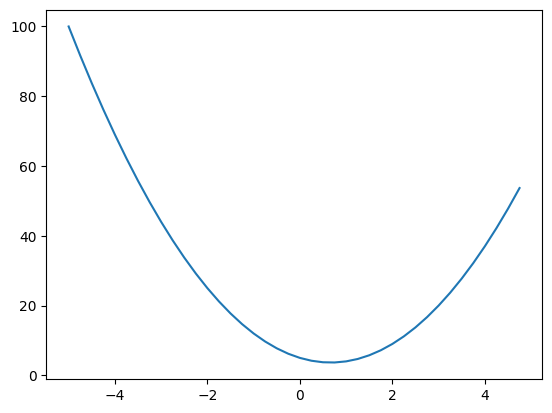

In [9]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [23]:
from decimal import *
getcontext().prec = 12
h = Decimal(0.0000000001)
x = Decimal(2)
(f(x + h) - f(x))/h

Decimal('8.00000000000')

### Более сложный пример

In [24]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [28]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


https://pytorch.org/tutorials/beginner/examples_autograd/polynomial_custom_function.html

In [ ]:
from torch.autograd import Function

In [ ]:
class Exp(Function):
  """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """

  @staticmethod
  def forward(ctx, i):
    """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
    """
    result = i.exp()
    ctx.save_for_backward(result)
    return result

  @staticmethod
  def backward(ctx, grad_output):
    """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
    """
    print(ctx.saved_tensors)
    result, = ctx.saved_tensors
    return grad_output * result

In [ ]:
# Use it by calling the apply method
input = torch.tensor(2.0, requires_grad=True)
output = Exp.apply(input)
output

tensor(7.3891, grad_fn=<ExpBackward>)

In [ ]:
import math
math.exp(2.0)

7.38905609893065

In [ ]:
output.backward()
show_tensor_params(output)
show_tensor_params(input)

(tensor(7.3891, grad_fn=<ExpBackward>),)
---
data - 7.389056205749512
grad - None
grad_fn - <torch.autograd.function.ExpBackward object at 0x7f2d47309e50>
req_grad - True
is_leaf - False
---
data - 2.0
grad - 7.389056205749512
grad_fn - None
req_grad - True
is_leaf - True


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1083: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  aten/src/ATen/core/TensorBody.h:477.)
  return self._grad


**Задание**: реализуйте backward для Polynomial 0.5 * (5 * input ** 3 - 3 * input)

In [ ]:
import torch


class Polynomial(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        return 0.5 * (5 * input ** 3 - 3 * input)

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        input, = ctx.saved_tensors
        return (7.5 * input ** 2 - 1.5) * grad_output

Практическое задание: написать собственный движок автоматического дифференцирования, а именно: реализовать

In [251]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None # function
        self._prev = set(_children) # set of Value objects
        self._op = _op # the op that produced this node, string ('+', '-', ....)

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, _children=[self, other], _op="+")

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, _children=[self, other], _op="*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, _children=[self], _op="**")

        def _backward():
            self.grad += other * (self.data) ** (other - 1) * out.grad
            print(self)
        out._backward = _backward

        return out

    def relu(self):
        out = Value(max(0.0, self.data), _children=[self], _op="relu")

        def _backward():
            self.grad += (1 if self.data > 0 else 0) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self.__add__(other)

    def __sub__(self, other): # self - other
        return self.__add__(-other)

    def __rsub__(self, other): # other - self
        return self.__neg__().__add__(other)

    def __rmul__(self, other): # other * self
        return self.__mul__(other)

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

In [252]:
def test_sanity_check():

    x = Value(-4.0)
    z = 2 * x + 2 + x

    q = z.relu() + z * x
    h = (z * z).relu()
    y = h + q + q * x
    y.backward()
    print(x, z, q, h, y)
    xmg, ymg = x, y

    x = torch.Tensor([-4.0]).double()
    x.requires_grad = True
    z = 2 * x + 2 + x
    z.retain_grad()
    q = z.relu() + z * x
    q.retain_grad()
    h = (z * z).relu()
    h.retain_grad()
    y = h + q + q * x
    y.retain_grad()
    y.backward()
    print(x.grad, z.grad, q.grad, h.grad, y.grad)
    xpt, ypt = x, y
    """
    x = Value(-4.0)

    z = x * 2
    a = z ** 2
    b = a + 3
    y = b * 2 - b
    y.backward()
    xmg, ymg = x, y
    print(y, b, a, z, x)

    x = torch.Tensor([-4.0]).double()
    x.requires_grad = True
    z = x * 2
    z.retain_grad()
    a = z ** 2
    a.retain_grad()
    b = a + 3
    b.retain_grad()
    y = b * 2 - b
    y.retain_grad()
    y.backward()
    print(y.grad, b.grad, a.grad, z.grad, x.grad)
    xpt, ypt = x, y
    """


    # forward pass went well
    assert ymg.data == ypt.data.item()
    # backward pass went well
    print(xmg, xpt, xpt.grad)
    assert xmg.grad == xpt.grad.item()


def test_more_ops():

    a = Value(-4.0)
    b = Value(2.0)
    c = a + b
    d = a * b + b**3
    c += c + 1
    c += 1 + c + (-a)
    d += d * 2 + (b + a).relu()
    d += 3 * d + (b - a).relu()
    e = c - d
    f = e**2
    g = f / 2.0
    g += 10.0 / f
    g.backward()
    amg, bmg, gmg = a, b, g

    a = torch.Tensor([-4.0]).double()
    b = torch.Tensor([2.0]).double()
    a.requires_grad = True
    b.requires_grad = True
    c = a + b
    d = a * b + b**3
    c = c + c + 1
    c = c + 1 + c + (-a)
    d = d + d * 2 + (b + a).relu()
    d = d + 3 * d + (b - a).relu()
    e = c - d
    f = e**2
    g = f / 2.0
    g = g + 10.0 / f
    g.backward()
    apt, bpt, gpt = a, b, g

    tol = 1e-6
    # forward pass went well
    assert abs(gmg.data - gpt.data.item()) < tol
    # backward pass went well
    assert abs(amg.grad - apt.grad.item()) < tol
    assert abs(bmg.grad - bpt.grad.item()) < tol

In [236]:
a = Value(-4.0)
b = Value(2.0)
d = Value(3.0)

In [237]:
c = a + b
e = c * d
e.backward()

In [253]:
test_sanity_check()

Value(data=-4.0, grad=46.0) Value(data=-10.0, grad=-8.0) Value(data=40.0, grad=-3.0) Value(data=100.0, grad=1) Value(data=-20.0, grad=1)
tensor([46.], dtype=torch.float64) tensor([-8.], dtype=torch.float64) tensor([-3.], dtype=torch.float64) tensor([1.], dtype=torch.float64) tensor([1.], dtype=torch.float64)
Value(data=-4.0, grad=46.0) tensor([-4.], dtype=torch.float64, requires_grad=True) tensor([46.], dtype=torch.float64)


In [254]:
test_more_ops()

Value(data=49.0, grad=0.4958350687213661)
Value(data=-7.0, grad=-6.941690962099126)
Value(data=2.0, grad=978.7784256559768)


# Обучение на основе собственной бибилотеки

## Многослойный перцептрон на основе класса Value

In [330]:
import random

class Module:

    def zero_grad(self):
        for p in self.parameters():
          p.grad = 0

    def parameters(self):
        return []

class Neuron(Module):

    def __init__(self, nin, nonlin=True):
        self.w = [Value(random.randint(1, 5)) for _ in range(nin)]
        self.b = Value(random.randint(1, 3)) #
        self.nonlin = nonlin

    def __call__(self, x):
        print(x)
        act = sum([self.w[i] * x[i] for i in range(len(x))]) + self.b
        return act.relu() if self.nonlin else act

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

class Layer(Module):

    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        out = [self.neurons[i](x) for i in range(len(self.neurons))]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return self.neurons

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP(Module):

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        print(sz)
        self.layers = [Layer(sz[i], sz[i+1], nonlin=(i!=len(nouts)-1)) for i in range(len(nouts))]

    def __call__(self, x):

        x1 = [self.layers[0](x[i]) for i in range(len(x))]
        x2 = [self.layers[1](x1[i]) for i in range(len(x1))]
        x3 = [self.layers[2](x2[i]) for i in range(len(x2))]
        print(x1, x2, x3, sep = "-----------------------------------\n")

        return x3

    def parameters(self):
        return self.layers

    def __repr__(self):
        repr = '\n'.join(str(layer) for layer in self.layers)
        return f"MLP of [{repr}]"

## Обучение многослойного перцептрона

Сам перцептрон

In [331]:
nn = MLP(3, [4, 4, 1])
print(nn)
print("number of parameters", len(nn.parameters()))
[[j.parameters() for j in i.neurons] for i in nn.layers]

[3, 4, 4, 1]
MLP of [Layer of [ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3)]
Layer of [ReLUNeuron(4), ReLUNeuron(4), ReLUNeuron(4), ReLUNeuron(4)]
Layer of [ReLUNeuron(4)]]
number of parameters 3


[[[Value(data=5, grad=0),
   Value(data=4, grad=0),
   Value(data=1, grad=0),
   Value(data=3, grad=0)],
  [Value(data=5, grad=0),
   Value(data=2, grad=0),
   Value(data=1, grad=0),
   Value(data=3, grad=0)],
  [Value(data=5, grad=0),
   Value(data=1, grad=0),
   Value(data=5, grad=0),
   Value(data=3, grad=0)],
  [Value(data=4, grad=0),
   Value(data=2, grad=0),
   Value(data=5, grad=0),
   Value(data=1, grad=0)]],
 [[Value(data=3, grad=0),
   Value(data=3, grad=0),
   Value(data=3, grad=0),
   Value(data=2, grad=0),
   Value(data=3, grad=0)],
  [Value(data=1, grad=0),
   Value(data=3, grad=0),
   Value(data=2, grad=0),
   Value(data=2, grad=0),
   Value(data=2, grad=0)],
  [Value(data=3, grad=0),
   Value(data=3, grad=0),
   Value(data=3, grad=0),
   Value(data=4, grad=0),
   Value(data=2, grad=0)],
  [Value(data=5, grad=0),
   Value(data=1, grad=0),
   Value(data=1, grad=0),
   Value(data=3, grad=0),
   Value(data=1, grad=0)]],
 [[Value(data=3, grad=0),
   Value(data=2, grad=0),
  

Набор данных

In [333]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
print(nn(xs)) #TODO nn(xs[i]) = y[i]

2.0


TypeError: ignored

In [292]:
for k in range(20):

    # forward
    ...

    # calculate loss (mean square error)
    ...

    # backward (zero_grad + backward)
    ...

    # update
    learning_rate = ...
    for p in n.parameters():
        ...

    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

NameError: ignored

# Домашнее задание

**Домашнее задание 1.** Доделать практику. Оформить код в три отдельных модуля `autograd`, `nn`, `train`

**Домашнее задание 2 (Опционально).** Создать свою функцию softmax, наследуемую от `torch.autograd.Function` и имплементировать forward и backward проход. Сравнить со стандартной функцией в Pytorch.
[Создание функций](https://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_custom_function.html) [Софтмакс](https://congyuzhou.medium.com/softmax-3408fb42d55a)

In [ ]:
from re import I
input = torch.tensor([2.1, 2.0, 2.0, 8.8], requires_grad=True)
sm = torch.nn.Softmax(dim=0)
output = sm(input)
output

tensor([0.0012, 0.0011, 0.0011, 0.9966], grad_fn=<SoftmaxBackward0>)

In [ ]:
output.sum().backward()
show_tensor_params(input)

---
data - tensor([2.1000, 2.0000, 2.0000, 8.8000])
grad - tensor([7.3115e-11, 6.6157e-11, 6.6157e-11, 5.9399e-08])
grad_fn - None
req_grad - True
is_leaf - True


In [ ]:
input = torch.tensor([2.1, 2.0, 2.0, 8.8], requires_grad=True)
sm = torch.nn.Softmax(dim=0)
output = sm(input)
ground_true = torch.tensor([0., 0., 0., 1.])


loss = (output - ground_true) ** 2
loss = loss.sum().backward()
show_tensor_params(input)

---
data - tensor([2.1000, 2.0000, 2.0000, 8.8000])
grad - tensor([ 1.1426e-05,  1.0080e-05,  1.0080e-05, -3.1586e-05])
grad_fn - None
req_grad - True
is_leaf - True


In [ ]:
input = torch.tensor([2.1, 2.0, 2.0, 8.8], requires_grad=True)
sm = torch.nn.Softmax(dim=0)
output = sm(input)
ground_true = torch.tensor([1., 1., 0., 1.])


loss = (output - ground_true) ** 2
loss = loss.sum().backward()
show_tensor_params(input)

---
data - tensor([2.1000, 2.0000, 2.0000, 8.8000])
grad - tensor([-2.4362e-03, -2.2046e-03,  1.5267e-05,  4.6255e-03])
grad_fn - None
req_grad - True
is_leaf - True


**Домашнее задание 3 (Продвинутая группа).** Добавить функцию софтмакс в собственну библиотеку автоматического дифференцирования. Сравнить с пунктом 2

In [ ]:
# Ваш код

**Домашнее задание 4 (Продвинутая группа).** Добавить визуализацию обучения. Потом мы пройдем более подробно.

https://docs.wandb.ai/guides/integrations/pytorch

https://docs.wandb.ai/ref/python/watch  

https://docs.wandb.ai/guides/track/jupyter

In [ ]:
!pip install wandb

In [ ]:
!wandb login

In [ ]:
import wandb
run = wandb.init(project="polynom_learning_")

In [ ]:
run.finish()